# Predict CriptoCurrency Price with ML

<div style="display:none">
    Based on:
    https://www.geeksforgeeks.org/bitcoin-price-prediction-using-machine-learning-in-python/
</div>

In [1]:
import yfinance as yf
from datetime import date, timedelta
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Defining dates for the dataset
start_date = '2014-01-01'
end_date = date.today() - timedelta(days=1)

In [3]:
currency = 'BTC-USD'

In [4]:
# Importing Dataset
df= yf.download(currency, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [5]:
df.shape

(3363, 6)

In [6]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-11-27,37454.191406,37559.355469,36750.128906,37254.167969,37254.167969,19002925720
2023-11-28,37247.992188,38368.480469,36891.089844,37831.085938,37831.085938,21696137014
2023-11-29,37826.105469,38366.113281,37612.632812,37858.492188,37858.492188,20728546658


In [7]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3.363000e+03
mean,14322.428809,14659.485504,13958.737930,14332.473961,14332.473961,1.648901e+10
std,16040.155997,16429.306906,15602.517053,16040.861363,16040.861363,1.914707e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,901.023499,914.279480,884.140991,901.871490,901.871490,1.494235e+08
50%,8189.771973,8308.450195,7956.774414,8192.494141,8192.494141,1.108310e+10
75%,23189.826172,23669.445312,22790.122070,23205.432617,23205.432617,2.687238e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3363 entries, 2014-09-17 to 2023-12-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3363 non-null   float64
 1   High       3363 non-null   float64
 2   Low        3363 non-null   float64
 3   Close      3363 non-null   float64
 4   Adj Close  3363 non-null   float64
 5   Volume     3363 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 183.9 KB


# Exploratory Data Analysis
EDA is an approach to analyzing the data using visual techniques. It is used to discover trends, and patterns, or to check assumptions with the help of statistical summaries and graphical representations. 

While performing the EDA of the Bitcoin Price data we will analyze how prices of the cryptocurrency have moved over the period of time and how the end of the quarters affects the prices of the currency.

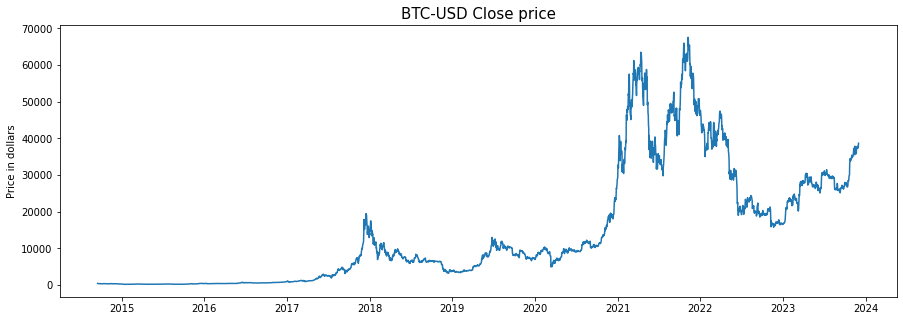

In [9]:
plt.figure(figsize=(15,5))
plt.plot(df['Close'])
plt.title(f'{currency} Close price', fontsize=15)
plt.ylabel('Price in dollars')
plt.show()

The prices of the Bitcoin stocks are showing an upward trend as depicted by the plot of the closing price of the stocks.

In [10]:
# Checking the values in column 'Close' and 'Adj Close' : are they equals?
print(df['Close'].equals(df['Adj Close']))

True


 ‘Close’ and ‘Adj Close’ have the same data. So, having redundant data in the dataset is not useful, we’ll drop this column before further analysis.

In [11]:
df= df.drop(['Adj Close'], axis=1)

In [12]:
# Checking for null values
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [13]:
# Now let’s draw the distribution plot for the continuous features given in the dataset
features = list(df.columns)
features.pop()  # Exclude Volume
features

['Open', 'High', 'Low', 'Close']

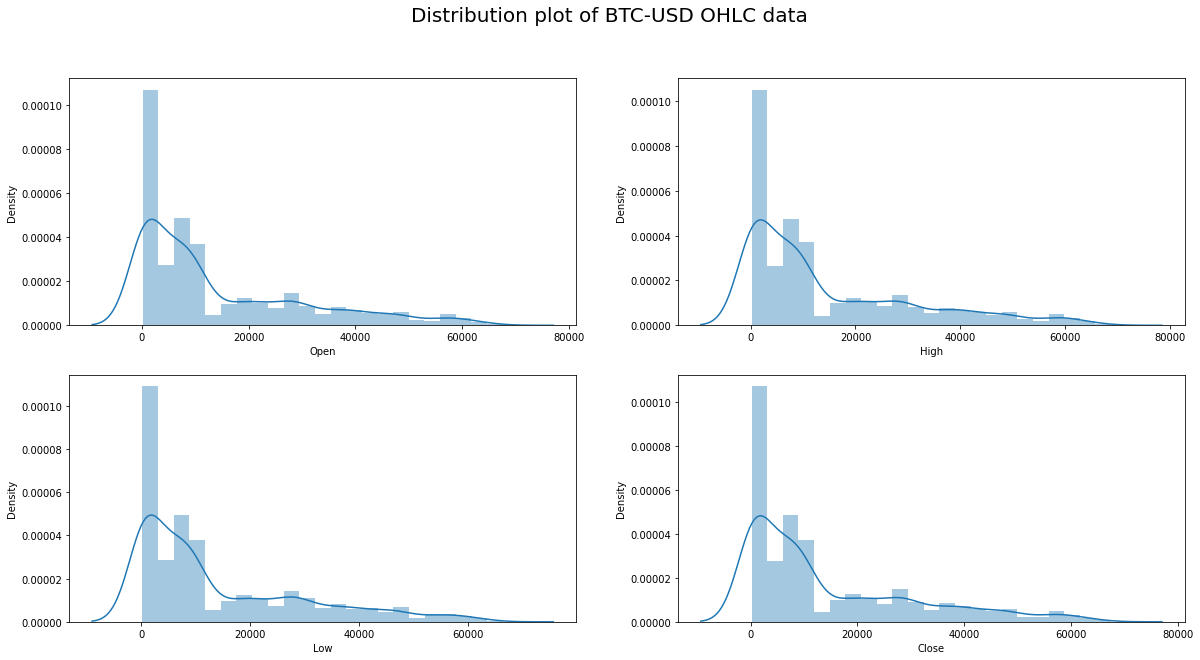

In [14]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
    plt.subplot(2,2,i+1)
    sb.distplot(df[col])
plt.suptitle(f"Distribution plot of {currency} OHLC data", fontsize=20)
plt.show()

In [15]:
from scipy.stats import skew
simetria = skew(df['Close'])
simetria

1.2477328476463938

This value indicate the distribution has a positive tail and is skewed to the right, with most of the values on the left side and some larger values on the right side.

In [16]:
from scipy.stats import kurtosis
curtosis = kurtosis(df['Close'], fisher=True)
curtosis

0.61583067389715

Since this value is positive, it suggests that the distribution has relatively lighter tails than a normal distribution. A positive kurtosis implies that the data has fewer extreme values (outliers) than would be expected in a normal distribution.

In [17]:
# delete?
media = df['Close'].mean()
mediana = df['Close'].mode()
moda = df['Close'].median()

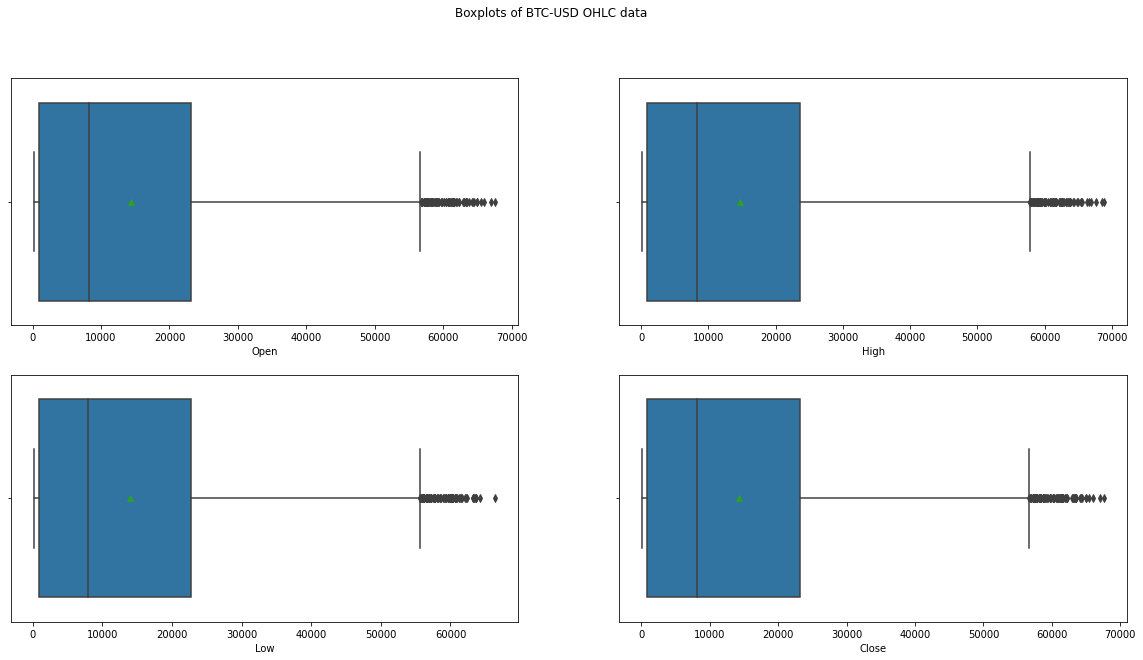

In [18]:
# boxplots
plt.subplots(figsize=(20,10))
plt.suptitle(f'Boxplots of {currency} OHLC data')
for i, col in enumerate(features):
    plt.subplot(2,2,i+1)
    sb.boxplot(df[col], showmeans=True)
plt.show()

large spread of data, asimetric positive. There are so many outliers in the data which means that the prices of the stock have varied hugely in a very short period of time.

## Feature Engineering
Feature Engineering helps to derive some valuable features from the existing ones. These extra features sometimes help in increasing the performance of the model significantly and certainly help to gain deeper insights into the data.

In [20]:
# Lets create new columns for year. month and day
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['name_day'] = df.index.day_name()
df.head()

,Open,High,Low,Close,Volume,year,month,day,name_day
Date,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17,Wednesday
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18,Thursday
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19,Friday
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20,Saturday
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21,Sunday


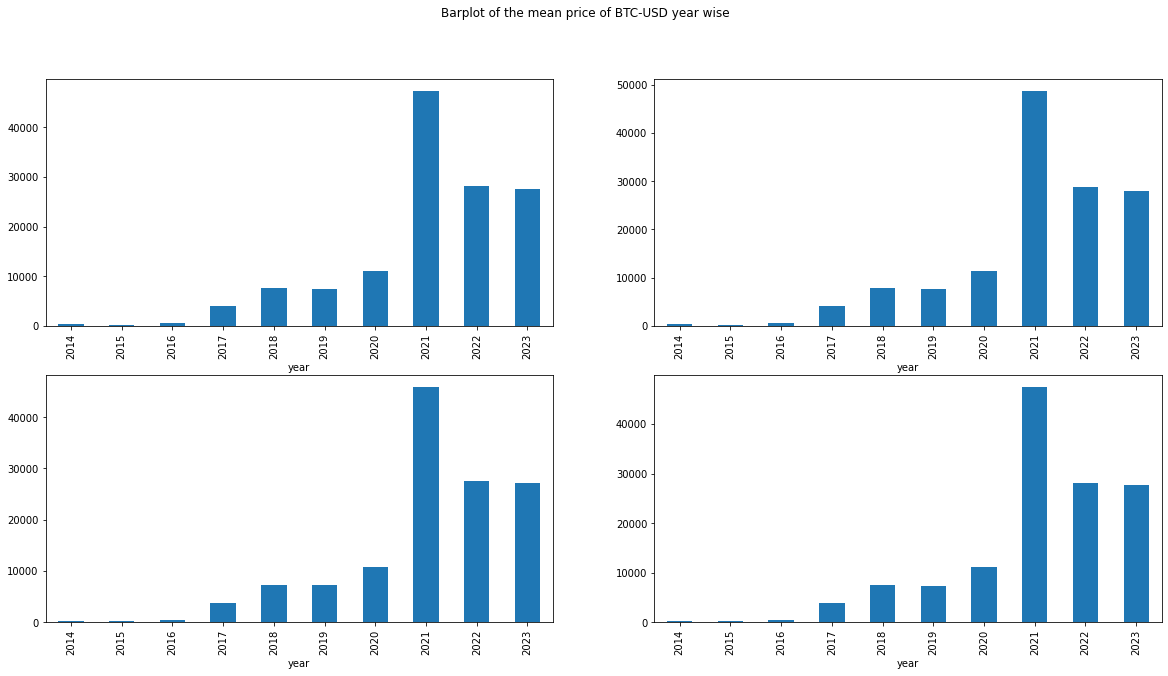

In [21]:
data_grouped_by_year = df.groupby('year').mean()
plt.subplots(figsize=(20,10))
plt.suptitle(f'Barplot of the mean price of {currency} year wise')
for i, col in enumerate(features):
    plt.subplot(2,2,i+1)
    data_grouped_by_year[col].plot.bar()
plt.show()

Here we can observe why there are so many outliers in the data as the prices of bitcoin have exploded in the year 2021.

In [22]:
df['open-close'] = df['Open'] - df['Close']
df['low-high'] = df['Low'] - df['High']
""" 
This instruction creates a new column named target in the DataFrame df. The values in this column are 1 if the corresponding value in the Close column is higher than the previous value in the Close column, and 0 otherwise 
"""
df['Target'] = np.where(df['Close'] > df['Close'].shift(1),1,0)

Above we have added some more columns which will help in the training of our model. We have added the target feature which is a signal whether to buy or not we will train our model to predict this only. But before proceeding let’s check whether the target is balanced or not using a pie chart.

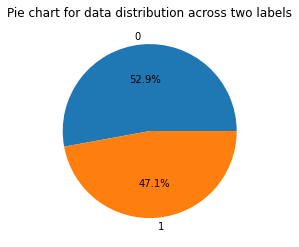

In [23]:
plt.pie(df['Target'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.title("Pie chart for data distribution across two labels")
plt.show()

When we add features to our dataset we have to ensure that there are no highly correlated features as they do not help in the learning process of the algorithm.

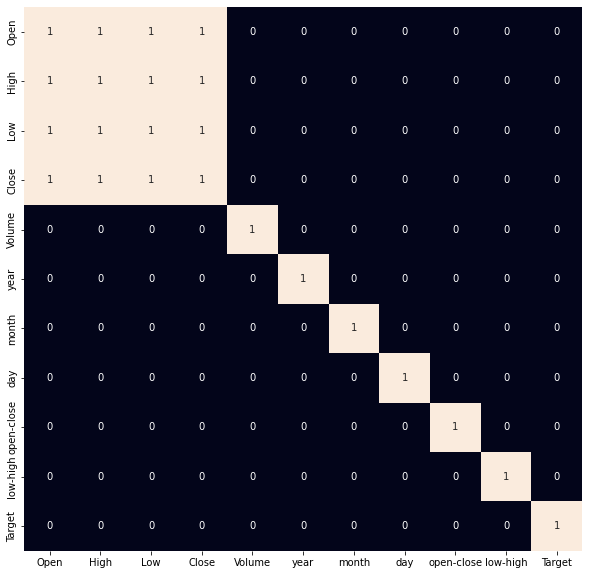

In [24]:
plt.figure(figsize=(10,10))
# As our concern is with the highly
# correlated features only so, we will visualize
# our heatmap as per that criteria only.
sb.heatmap(df.corr() > 0.9, annot=True, cbar=False)
plt.show()

From the above heatmap, we can say that there is a high correlation between OHLC which is pretty obvious, and the added features are not highly correlated with each other or previously provided features which means that we are good to go and build our model.

In [26]:
features = df[['month', 'open-close', 'low-high']]
target = df['Target']

scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=2022)
print(f'the training set has {X_train.shape[0]} data points and {X_train.shape[1]} \
features each, \nand the validation set has {X_valid.shape[0]} data points with \
{X_valid.shape[1]} features each')

the training set has 3026 data points and 3 features each, 
and the validation set has 337 data points with 3 features each


After selecting the features to train the model on we should normalize the data because normalized data leads to stable and fast training of the model. After that whole data has been split into two parts with a 90/10 ratio so, that we can evaluate the performance of our model on unseen data.

### Model Development and Evaluation
Now is the time to train some state-of-the-art machine learning models(Logistic Regression, Support Vector Machine, XGBClassifier), and then based on their performance on the training and validation data we will choose which ML model is serving the purpose at hand better.

For the evaluation metric, we will use the ROC-AUC curve but why this is because instead of predicting the hard probability that is 0 or 1 we would like it to predict soft probabilities that are continuous values between 0 to 1. And with soft probabilities, the ROC-AUC curve is generally used to measure the accuracy of the predictions.

In [27]:
models = [LogisticRegression(), SVC(kernel='poly', probability=True), XGBClassifier()]
print('Performance of different state-of-the-art models'.center(80))
for i in range(3):
    models[i].fit(X_train, Y_train)
    print('==================')
    print(f'{models[i]} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(Y_train, models[i].predict_proba(X_train)[:,1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(Y_valid, models[i].predict_proba(X_valid)[:,1]))

                Performance of different state-of-the-art models                
LogisticRegression() : 
Training Accuracy :  0.9947130451529318
Validation Accuracy :  0.995930528304629


SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.9520352959714271
Validation Accuracy :  0.955272145919628
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) : 
Training Accuracy :  1.0
Validation Accuracy :  0.9987282900951966


Among the three models, we have trained XGBClassifier has the highest performance but it is pruned to overfitting. But in the case of the Logistic Regression, this is not the case.

Now let’s plot a confusion matrix for the validation data.

In [28]:
y_pred = models[0].predict(X_valid)
confusion_matrix = confusion_matrix(Y_valid, y_pred)

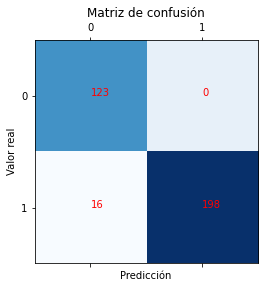

In [30]:
plt.matshow(confusion_matrix, cmap='Blues')
plt.title('Matriz de confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor real')
for i in range(confusion_matrix.shape[0]):
  for j in range(confusion_matrix.shape[1]):
    plt.annotate(str(confusion_matrix[i, j]), (i, j),
                  color='red', size='medium')
plt.show()

In [33]:
features1 = df[['month', 'open-close', 'low-high']]
features1

,month,open-close,low-high
Date,,,
2014-09-17,9,8.529999,-15.752014
2014-09-18,9,32.419983,-43.755981
2014-09-19,9,29.307007,-43.302979
2014-09-20,9,-14.230988,-33.412994
2014-09-21,9,9.263977,-19.244995
...,...,...,...
2023-11-27,11,200.023438,-809.226562
2023-11-28,11,-583.093750,-1477.390625
2023-11-29,11,-32.386719,-753.480469


# Conclusion
The model apparently works well, but does it make sense? To make a prediction of the rise or fall of the price of the cryptocurrency, you have to feed the model with data that we also do not have, such as 'open-close' and 'low-hig'